# Checkpoint 2

Implement here your algorithm to estimate the unknown parameters (fiber angle, anisotropy ratio and starting point position) from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of the fiber angle, anisotropy ratio and starting point position


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy.interpolate as spi

#!pip -q install pyDOE

from tensorflow import keras
from tensorflow.keras import regularizers
from pyDOE import lhs  # for latin hypercube sampling
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

In [ ]:
# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# loading of the dataset
CP2data = np.load("CP2data.npz")['arr_0']

## Display one recording

In [14]:
# Select an example recording for visualization
ind_disp = 2  # Index of the sample to display
x_meas = CP2data[ind_disp][0]  # X-coordinates of electrode measurements
y_meas = CP2data[ind_disp][1]  # Y-coordinates of electrode measurements
t_meas = CP2data[ind_disp][2]  # Activation times at each electrode

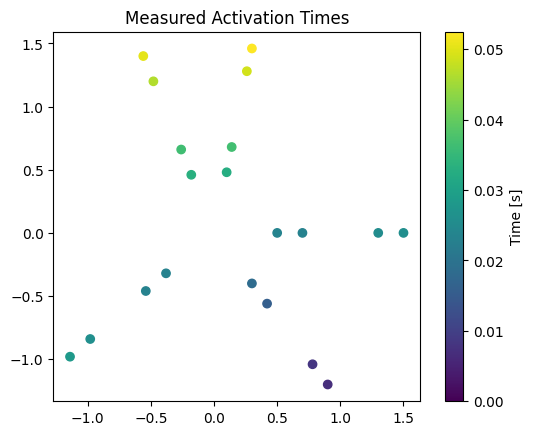

In [15]:
# Scatter plot of activation times at measurement points
plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar(label='Time [s]')
plt.title("Measured Activation Times")
plt.show()

In [16]:
# loading of estimates
CP2estimate = np.load("CP2estimate.npz")['arr_0']

In [17]:
theta_true = CP2estimate[ind_disp][0]
a_ratio_true  = CP2estimate[ind_disp][1]
y0_true = CP2estimate[ind_disp][2]

## Signature of the function

def checkpoint2_solution( x, y , t ):

return theta_fiber, a_ratio, y0



In [10]:
# Create a structured grid for interpolation (1501x1501 points in a square region)
X1, Y1 = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

# Compute only activation time
def checkpoint1_solution(x,y,t,X,Y):
  """
    Function to interpolate activation times.
    
    Parameters:
    x, y, t : Measured data points (positions and activation times)
    X, Y    : Grid points where predictions are made
    
    Returns:
    time_pred    : Interpolated activation time field
    """
  # Interpolate activation times using radial basis function (thin plate spline)
  interp = spi.RBFInterpolator(list(zip(x, y)), t, smoothing=0.1, kernel='thin_plate_spline', epsilon=1.5)
  time_pred = interp(np.vstack((X.ravel(), Y.ravel())).T).reshape(X.shape)

  return time_pred

In [18]:
# Run the function on the selected data sample
time_pred = checkpoint1_solution(CP2data[ind_disp][0], CP2data[ind_disp][1] , CP2data[ind_disp][2], X1 , Y1 )

# Compute the guess for the starting point y0
min_index = np.unravel_index(np.argmin(time_pred),time_pred.shape)[0]
guess_y0 = np.linspace(-1.5,1.5,1501)[min_index] 
print(guess_y0)

-1.5


In [ ]:
# Create a class for the specific activation function
class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})

In [ ]:
# Construct the necessary functions for PINN

# Function to apply penalty constraints on parameters
def penalty(param, lower_bound, upper_bound):
    """
    Computes a penalty term that ensures the parameter values stay within specified bounds.
    
    Parameters:
    param: TensorFlow tensor - the parameter to constrain
    lower_bound: float - minimum allowed value for the parameter
    upper_bound: float - maximum allowed value for the parameter
    
    Returns:
    Penalty value (sum of squared violations beyond the bounds)
    """
    return tf.reduce_sum(tf.square(tf.maximum(param - upper_bound, 0)) + tf.square(tf.maximum(lower_bound - param, 0)))



# PINN loss function
def loss(xcl, ycl, x_meas, y_meas, t_meas, param):
    """
    Computes the loss for the Physics-Informed Neural Network (PINN).

    Parameters:
    xcl, ycl: Tensors - collocation points for enforcing physics constraints
    x_meas, y_meas: Tensors - measurement locations
    t_meas: Tensor - measured activation times
    param: Tensor - model parameters

    Returns:
    Total loss value combining measurement error, residual loss, initial condition loss, and parameter penalties
    """
    # Predicted activation times at measured points
    t_meas_pred = PINN(tf.concat([x_meas, y_meas], 1))

    # Residual loss enforcing PDE constraints
    r_pred = r_PINN(xcl, ycl, param)

    # Loss for satisfying initial conditions
    r_stat = s_PINN(param)

    # Compute different components of the loss function
    mse_meas = tf.reduce_mean(tf.pow(t_meas - t_meas_pred, 2))  # Mean squared error for measurements
    mse_r = tf.reduce_mean(tf.pow(r_pred, 2))  # Residual loss
    mse_start = tf.reduce_mean(tf.pow(r_stat, 2))  # Initial state loss

    # Parameter penalties to enforce constraints on model parameters
    mse_penalty = (penalty(param[0], -np.pi/10, np.pi/10) + 
                   penalty(param[1], 1, 9) + 
                   penalty(param[2], -1.5, 1.5))

    # Total loss is the sum of all components
    return mse_r + mse_meas + mse_start + mse_penalty


@tf.function
def grad(model,xcl,ycl,x_meas,y_meas,t_meas,param):
    """
    Computes the gradient of the loss function with respect to both model parameters and trainable variables.

    Parameters:
    model: TensorFlow model - PINN
    xcl, ycl: Tensors - collocation points
    x_meas, y_meas: Tensors - measurement locations
    t_meas: Tensor - measured activation times
    param: Tensor - model parameters

    Returns:
    loss_value: Computed loss
    grads: Gradients wrt trainable model parameters
    grad_param: Gradients wrt additional parameters
    """
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,x_meas,y_meas,t_meas,param)
        grads = tape.gradient(loss_value,model.trainable_variables)  # Compute gradients wrt model parameters
        grad_param =  tape.gradient(loss_value,param) # Compute gradients wrt extra parameters
    return loss_value, grads, grad_param

# Regularization strength
reg= 1e-3

# Define the Physics-Informed Neural Network (PINN) model
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh',input_shape=(2,),kernel_initializer="glorot_normal", kernel_regularizer=regularizers.l2(reg), dtype=tf.float64),
    tf.keras.layers.Dense(64, activation='mish',kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(reg),dtype=tf.float64),
    tf.keras.layers.Dense(64, activation='tanh',kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(reg),dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(reg),dtype=tf.float64)
])


@tf.function
def r_PINN(x, y, param):
    """
    Computes the residual term enforcing the physics constraints in the PINN model.

    Parameters:
    x, y: Tensors - spatial coordinates
    param: Tensor - model parameters (mu1, mu2, mu3)

    Returns:
    Residual term enforcing the PDE constraints
    """
    # Compute predicted activation time from PINN
    u = PINN(tf.concat([x, y], 1))

    # Extract parameters
    pitf = tf.cast(np.pi/2, dtype=tf.float64)
    mu1, mu2, _ = param[0], param[1], tf.cast(param[2], dtype=tf.float32)

    # Compute rotation matrix components
    theta0 = pitf - mu1
    a = tf.cast(tf.stack([tf.cos(theta0), tf.sin(theta0)], axis=-1), dtype=tf.float64)
    b = tf.cast(tf.stack([tf.cos(theta0 - pitf), tf.sin(theta0 - pitf)], axis=-1), dtype=tf.float64)

    # Diffusion tensor computation
    D_00 = 1 / mu2 * a[0]**2 + b[0]**2
    D_01 = 1 / mu2 * a[0] * a[1] + b[0] * b[1]
    D_10 = D_01
    D_11 = 1 / mu2 * a[1]**2 + b[1]**2

    # Compute gradients of u w.r.t. x and y
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]

    # Compute residual enforcing PDE constraints
    return tf.sqrt((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)) - 1/100


@tf.function
def s_PINN(param):
    """
    Computes an initial condition constraint for the PINN.

    Parameters:
    param: Tensor - model parameters

    Returns:
    Constraint value at a specific point
    """
    mu3 = tf.cast(param[2], dtype=tf.float32)

    # Set fixed coordinates for initial condition
    xst = tf.expand_dims([1.5], axis=-1)
    yst = tf.expand_dims([mu3], axis=-1)

    # Compute loss at the initial condition point
    loss = PINN(tf.concat([xst, yst], 1))
    return loss

# Function to print parameter values during training
def print_param(param):
    """
    Prints the values of the model parameters.

    Parameters:
    param: List of TensorFlow tensors - model parameters
    """
    for pa in param:
        print(f"Parameter Value: {pa.numpy()}")
    print("-" * 50)

In [ ]:
def checkpoint2_solution( x, y, t):
    """
    Trains a Physics-Informed Neural Network (PINN) to estimate parameters based on measurement data.

    Parameters:
    x, y: Tensors - Spatial coordinates of measurement points
    t: Tensor - Corresponding measured activation times

    Returns:
    theta_fiber: Tensor - Estimated fiber orientation parameter
    a_ratio: Tensor - Estimated anisotropy ratio parameter
    y0: Tensor - Estimated initial y-coordinate parameter
    """
    # Expand dimensions to match expected input shape for the neural network
    x_meas = tf.expand_dims(x,axis= -1)
    y_meas = tf.expand_dims(y,axis= -1)
    t_meas = tf.expand_dims(t,axis= -1)

    # Generate collocation points using Sobol sampling for PDE constraints
    sampler = scipy.stats.qmc.Sobol(d=2, scramble=False)
    sample = sampler.random_base2(m=14) # Generate 2^14 quasi-random samples
    
    # Define the sampling bounds for spatial domain
    l_bounds = [-1.5, -1.5]  # Lower bounds
    u_bounds = [1.5, 1.5]  # Upper bounds 

    # Scale Sobol samples to fit within the defined bounds
    X =scipy.stats.qmc.scale(sample, l_bounds, u_bounds)

    # Extract x and y coordinates from scaled sample and convert to TensorFlow tensors
    xcl = tf.expand_dims(tf.cast(X[:,0],dtype=tf.float64),axis=-1)
    ycl = tf.expand_dims(tf.cast(X[:,1],dtype=tf.float64),axis=-1)

    # Define the optimizer (Adam)
    tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.99)

    # Initialize trainable parameters for the PINN
    m1 = tf.Variable(0.01, trainable=True, dtype=tf.float64)  # Initial guess for theta_fiber
    m2 = tf.Variable(4.0, trainable=True, dtype=tf.float64)   # Initial guess for anisotropy ratio
    m3 = tf.Variable(guess_y0, trainable=True, dtype=tf.float64)  # Initial guess for y0

    param = [m1, m2, m3]

    # Training loop
    for iter in range(10000):
      # Compute gradients of the loss function wrt model parameters
      loss_value,grads,grad_param = grad(PINN,xcl,ycl,x_meas,y_meas,t_meas,param)

      # Update both network weights and parameter variables
      tf_optimizer.apply_gradients(zip(grads+grad_param,PINN.trainable_variables+param))

      # Print progress every 200 iterations
      if ((iter+1) % 200 == 0):
        print('iter =  '+str(iter+1))
        print('loss = ',loss_value)
        print_param(param)

    # Extract final trained parameters
    theta_fiber, a_ratio, y0 = param
    return theta_fiber, a_ratio, y0

# Run the training function with given measurement data
theta_fiber, a_ratio, y0 = checkpoint2_solution(x_meas, y_meas, t_meas)